### División de datos Train-Validation-Test

In [ ]:
from sklearn.datasets import load_breast_cancer
import pandas as pd

data_breast = load_breast_cancer()

Transformar el dataset en un dataframe:

In [ ]:
df_data = pd.DataFrame(data_breast['data'],columns=data_breast['feature_names'])
df_data['target'] = data_breast['target']
features = data_breast['feature_names']
target = 'target'

Veamos qué tan balanceados están los datos:

In [ ]:
df_data['target'].value_counts(normalize=True)

1    0.627417
0    0.372583
Name: target, dtype: float64

Dividamos los datos usando splits de entrenamiento, validacion y prueba. Hagamos 70, 15, 15.

In [ ]:
#Con sklearn podemos dividir nuestros datos en conjuntos de entrenamiento, validación y prueba.

from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(df_data[features].values, df_data[target].values, test_size=0.3, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_test,y_test,test_size=0.5)


Podemos ver ahora como quedo

In [ ]:
print('Entrenamiento: {}'.format(len(x_train)))
print('Validacion: {}'.format(len(x_val)))
print('Prueba: {}'.format(len(x_test)))

Entrenamiento: 398
Validacion: 85
Prueba: 86


Tambien podemos ver como quedaron balanceadas las clases en cada split:

In [ ]:
for split_name, split in zip(['Entrenamiento','Validacion','Prueba'],[y_train,y_val,y_test]):
  print('{}: {:.3f}'.format(split_name,pd.Series(split).value_counts(normalize=True)[0]))

Entrenamiento: 0.374
Validacion: 0.341
Prueba: 0.395


Se puede observar que en cada uno de los splits, la proporción de las clases, por hacerse aleatoriamente la división, es distinta. Esto podría llegar a afectarnos. Una posibilidad es hacer splits estratificados:

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df_data[features].values, df_data[target].values, test_size=0.3, random_state=42,stratify=df_data[target].values)
x_val, x_test, y_val, y_test = train_test_split(x_test,y_test,test_size=0.5,stratify=y_test)

In [ ]:
print('Entrenamiento: {}'.format(len(x_train)))
print('Validacion: {}'.format(len(x_val)))
print('Prueba: {}'.format(len(x_test)))

Entrenamiento: 398
Validacion: 85
Prueba: 86


Ahora los splits tienen mas o menos el mismo balance

In [ ]:
for split_name, split in zip(['Entrenamiento','Validacion','Prueba'],[y_train,y_val,y_test]):
  print('{}: {:.3f}'.format(split_name,pd.Series(split).value_counts(normalize=True)[0]))

Entrenamiento: 0.372
Validacion: 0.376
Prueba: 0.372


Vamos a separarnos un set de evaluación

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df_data[features].values, df_data[target].values, test_size=0.3, random_state=42,stratify=df_data[target].values)

### Ejercicio 1 (20 minutos)

Hacer 100 divisiones distintas train-val. Medir accuracy, precision, recall y F1. Hacer un gráfico de caja y bigotes de estas métricas.

Comparar las gráficas de dos tipos de árboles:

* Árbol sencillo: profundidad < 10, min_samples_leaf>10, ccp_alpha=0.2

* Árbol complejo: profundidad > 20, min_samples_leaf<5, ccp_alpha=0

¿Cómo varían las distribuciones? ¿Por qué?

¿Para este problema, qué es preferible, un mayor precision o recall?

Graficar el árbol sencillo con sus decisiones

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


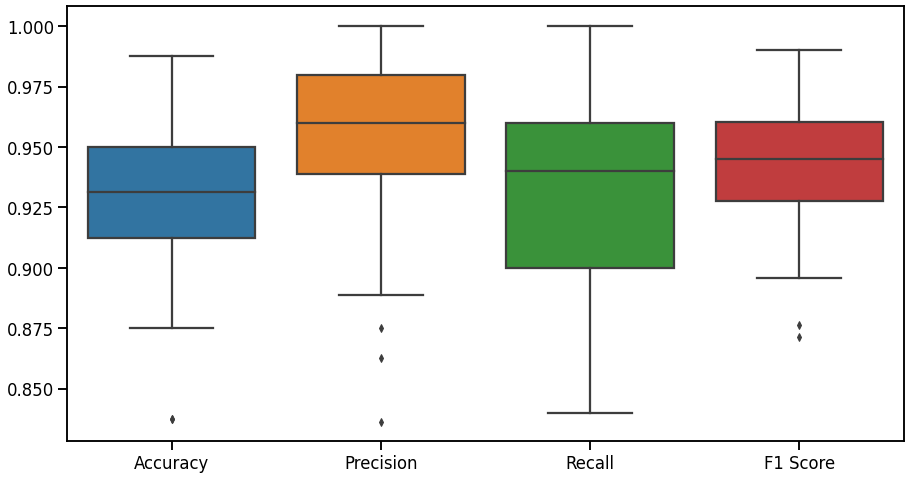

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.tree import plot_tree
import seaborn as sns
import matplotlib.pyplot as plt

n_seeds = 100
accs = []
precisions = []
recalls = []
f1s = []

for seed in range(n_seeds):
  x_train_, x_val, y_train_, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=seed,stratify=y_train)
  arbol_sklearn = DecisionTreeClassifier(criterion='entropy',max_depth=5,min_samples_leaf=10, ccp_alpha=0.01,class_weight='balanced')
  arbol_sklearn.fit(x_train_,y_train_)

  y_pred_val = arbol_sklearn.predict(x_val)
  accs.append(accuracy_score(y_val,y_pred_val))
  precisions.append(precision_score(y_val,y_pred_val))
  recalls.append(recall_score(y_val,y_pred_val))
  f1s.append(f1_score(y_val,y_pred_val))

all_metrics = accs + precisions + recalls + f1s
metric_labels = ['Accuracy']*len(accs) + ['Precision']*len(precisions) + ['Recall']*len(recalls) + ['F1 Score']*len(f1s)

sns.set_context('talk')
plt.figure(figsize=(15,8))
sns.boxplot(metric_labels,all_metrics)

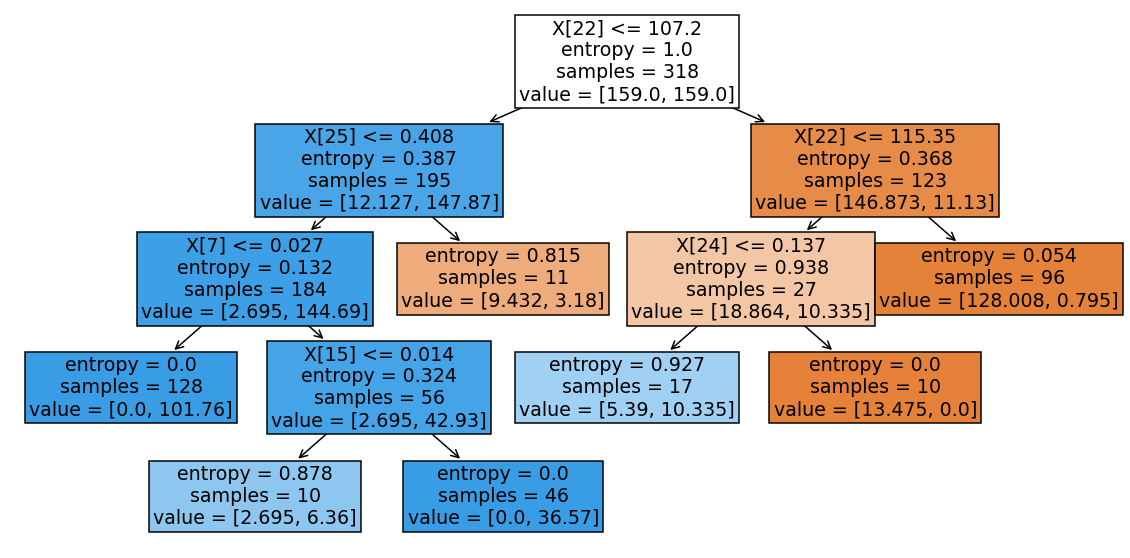

In [ ]:
plt.figure(figsize=(20,10))
plot_tree(arbol_sklearn,filled=True,proportion=False);

### Búsqueda de hiperparámetros y validación cruzada

Ahora queremos entrenar árboles de decisión. Teníamos varios **hiperparámetros** para decidir, como la profundidad, función de costo, número de instancias mínimo en una hoja, etc... Con sklearn, es posible explorar combinaciones de estos hiperparámetros asi elegimos la que mejores resultados den.

Ahora bien, tenemos que elegir una métrica en base a la cual tomar la decisión, y tenemos que tener datos en los que evaluar. En lugar de usar splits de entrenamiento-validación, vamos a usar k-fold cross-validation.

In [ ]:
from sklearn.model_selection import StratifiedKFold, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer
import numpy as np

params_grid = {'criterion':['gini','entropy'],
               'max_depth':list(range(1,30)),
               'ccp_alpha':np.linspace(0,0.5,100)}

kfoldcv = StratifiedKFold(n_splits=10)
base_tree = DecisionTreeClassifier()
scorer_fn = make_scorer(f1_score)
randomcv = RandomizedSearchCV(estimator=base_tree,param_distributions = params_grid,scoring=scorer_fn,cv=kfoldcv,n_iter=100)
randomcv.fit(x_train,y_train);

Podemos ver todas las combinaciones de parámetros y qué puntajes obtuvieron, junto a tiempos de entrenamiento y predicción.

In [ ]:
pd.DataFrame(randomcv.cv_results_).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_criterion,param_ccp_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.006366,0.001407,0.001254,0.000091,16,gini,0.409091,"{'max_depth': 16, 'criterion': 'gini', 'ccp_al...",0.769231,0.769231,0.769231,0.769231,0.769231,0.769231,0.769231,0.769231,0.781250,0.781250,0.771635,0.004808,78
1,0.005513,0.000439,0.001172,0.000080,6,gini,0.151515,"{'max_depth': 6, 'criterion': 'gini', 'ccp_alp...",0.943396,0.893617,0.941176,0.925926,0.888889,0.901961,0.892857,0.943396,0.941176,0.980392,0.925279,0.028498,17
2,0.005516,0.000366,0.001138,0.000035,28,gini,0.0808081,"{'max_depth': 28, 'criterion': 'gini', 'ccp_al...",0.943396,0.893617,0.941176,0.925926,0.888889,0.901961,0.892857,0.943396,0.941176,0.980392,0.925279,0.028498,17
3,0.007912,0.000910,0.001159,0.000081,12,entropy,0.186869,"{'max_depth': 12, 'criterion': 'entropy', 'ccp...",0.943396,0.893617,0.941176,0.901961,0.888889,0.901961,0.909091,0.938776,0.941176,0.960000,0.922004,0.024063,41
4,0.007400,0.000591,0.001034,0.000083,8,entropy,0.237374,"{'max_depth': 8, 'criterion': 'entropy', 'ccp_...",0.943396,0.893617,0.941176,0.901961,0.888889,0.901961,0.909091,0.938776,0.941176,0.960000,0.922004,0.024063,41


Podemos ver cuál fue la mejor combinación de hiperparámetros:

In [ ]:
randomcv.best_params_

{'ccp_alpha': 0.005050505050505051, 'criterion': 'entropy', 'max_depth': 3}

Podemos pedir el árbol correspondiente ya entrenado y ver cuán importante es cada atributo

In [ ]:
best_tree = randomcv.best_estimator_
feat_imps = best_tree.feature_importances_
feat_imps

array([0.        , 0.03261845, 0.        , 0.        , 0.        ,
       0.        , 0.05825024, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.01443104, 0.        ,
       0.67621801, 0.03587912, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.18260315, 0.        , 0.        ])

Se puede ver que una gran parte de los atributos fueron ignorados por el árbol y por eso valen cero. Es decir, el árbol no tomo ninguna decisión basándose en ellos. Ahora veamos a qué variables corresponden los índices con importancia mayor a 0

In [ ]:
for feat_imp,feat in sorted(zip(feat_imps,features)):
  if feat_imp>0:
    print('{}: {}'.format(feat,feat_imp))

symmetry error: 0.014431039788937894
mean texture: 0.03261844914346901
worst texture: 0.03587911510268348
mean concavity: 0.05825023581759141
worst concave points: 0.18260314874957892
worst radius: 0.6762180113977393


### Metricas

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

best_model = randomcv.best_estimator_
y_pred = best_model.predict(x_test)

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.95      0.91      0.93        64
           1       0.95      0.97      0.96       107

    accuracy                           0.95       171
   macro avg       0.95      0.94      0.94       171
weighted avg       0.95      0.95      0.95       171



Text(19.5, 0.5, 'True')

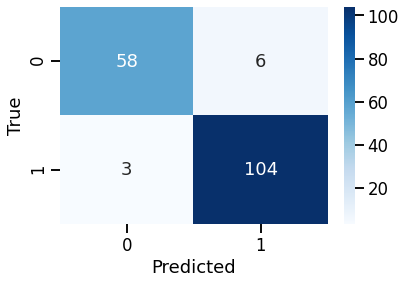

In [ ]:
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

A veces se utiliza la proporción de instancias en la hoja de la predicción como una probabilidad arrojada por el modelo. Si graficamos esas probabilidades para las instancias de ambas clases nos da algo asi:

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


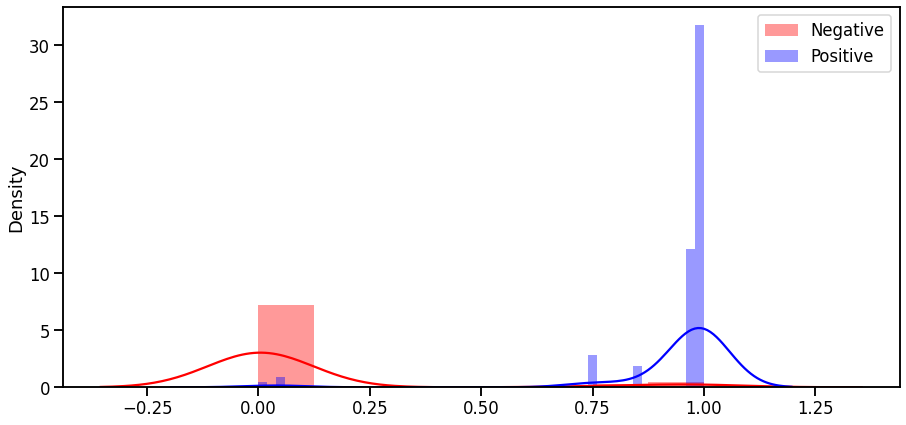

In [ ]:
y_scores = best_model.predict_proba(x_test)
out_probs = y_scores[:,1]

plt.figure(figsize=(15,7))
sns.distplot(out_probs[y_test==0],color='r',label='Negative')
sns.distplot(out_probs[y_test==1],color='b',label='Positive')
plt.legend()

El modelo nunca tiene incertidumbre (las probabilidades siempre estan cerca de 0 o 1, nunca de 0.5). Esto es porque justamente todas las hojas quedan bastante puras. Sin embargo, hay errores (curva roja donde debia estar azul y curva azul donde debia ser roja). Además se pueden observar picos, esto es porque las probabilidades son discretas en vez de continuas. Hay tantas probabilidades posibles como hojas tenga el árbol.

(0.0, 1.0)

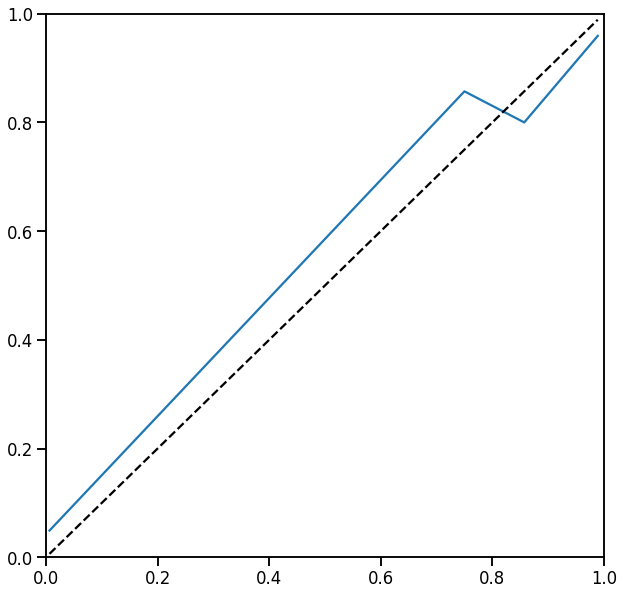

In [ ]:
from sklearn.calibration import calibration_curve

fraction_of_positives, mean_predicted_value = calibration_curve(y_test,out_probs,n_bins=10)
plt.figure(figsize=(10,10))
plt.plot(mean_predicted_value,fraction_of_positives)
plt.plot(mean_predicted_value,mean_predicted_value,'k--')
plt.ylim(0,1)
plt.xlim(0,1)

[ROC Curve](http://arogozhnikov.github.io/2015/10/05/roc-curve.html)

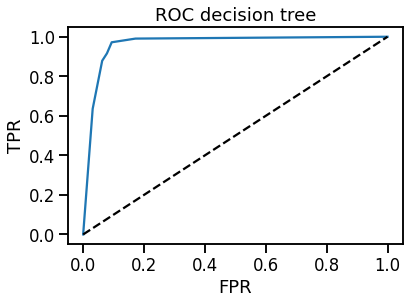

In [ ]:
from sklearn.metrics import roc_curve

fpr,tpr,th = roc_curve(y_test,out_probs)

plt.title('ROC decision tree')
plt.plot(fpr,tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.plot(fpr,fpr,'--k')

El principal problema de los árboles de decisión es que overfitean facilmente y son muy sensibles a los datos de entrada. Más adelante en la teoría, se verán los random forests, que basicamente son muchos árboles juntos. Podemos probar mirar las probabilidades que devuelve un random forest.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators=200)
forest.fit(x_train,y_train)
y_pred_rf = forest.predict_proba(x_test)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


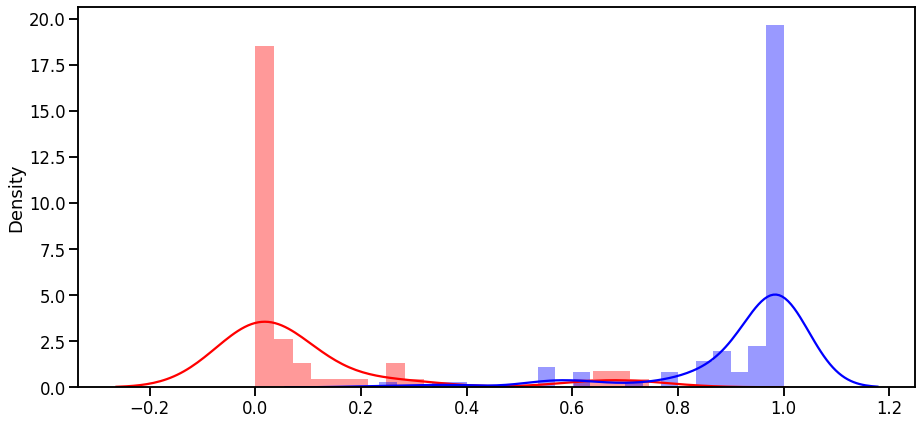

In [ ]:
out_probs = y_pred_rf[:,1]

plt.figure(figsize=(15,7))
sns.distplot(out_probs[y_test==0],color='r')
sns.distplot(out_probs[y_test==1],color='b')

Al menos tiene mejor pinta... Veamos si está calibrado:

(0.0, 1.0)

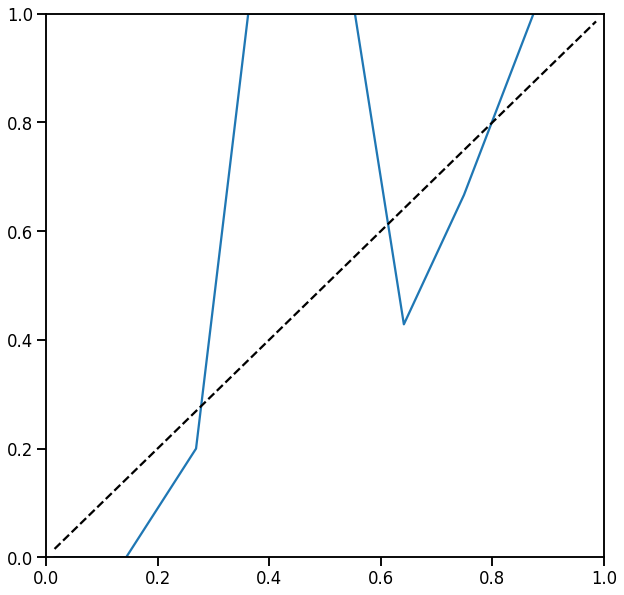

In [ ]:
fraction_of_positives, mean_predicted_value = calibration_curve(y_test,out_probs,n_bins=10)
plt.figure(figsize=(10,10))
plt.plot(mean_predicted_value,fraction_of_positives)
plt.plot(mean_predicted_value,mean_predicted_value,'k--')
plt.ylim(0,1)
plt.xlim(0,1)

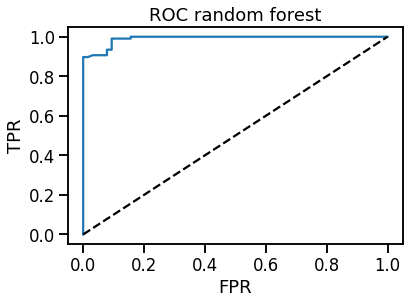

In [ ]:
fpr,tpr,th = roc_curve(y_test,out_probs)

plt.title('ROC random forest')
plt.plot(fpr,tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.plot(fpr,fpr,'--k')

### Efecto del balance

Métricas y desbalance

https://machinelearningmastery.com/tour-of-evaluation-metrics-for-imbalanced-classification/

Oversampling con SMOTE/ADASYN:

https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/

### Ejercicio 2 (20 minutos)

i) Crear datasets aleatorio en el que las proporciones de la clase 0 sean: [0.01,0.1,0.25,0.5,0.75,0.9,0.99].

ii) Usar StratifiedKFold con K=5, entrenar y validar en cada fold un árbol de decisiones. Utilizar el metodo split de StratifiedKFold. Realizar lo mismo para cada dataset creado en i). Reportar los valores de accuracy, recall, precision y F1.


In [ ]:
DATASET_SIZE = 10000
N_FEATURES = 30
x_random = np.random.uniform(size=(DATASET_SIZE,N_FEATURES))
y_randoms = []
props = [0.01,0.1,0.25,0.5,0.75,0.9,0.99]
for prop in props:
  y_i = np.ones(shape=(int(DATASET_SIZE,)))
  y_i[:int(DATASET_SIZE*(1-prop))] = 0
  y_randoms.append(y_i)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/usr/local/lib/python3.7/dist-packages/sklearn

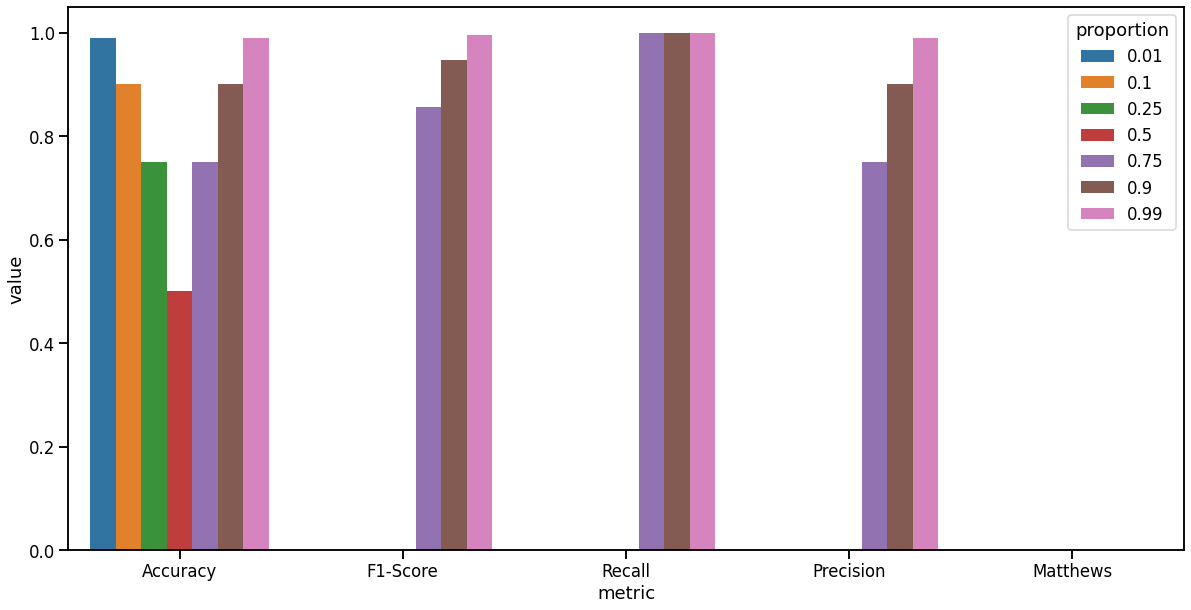

In [ ]:
from sklearn.metrics import matthews_corrcoef

metrics = []
proportions = []
vals = []
for prop,y in zip(props,y_randoms):
  tree = randomcv.best_estimator_
  kfoldcv = StratifiedKFold(n_splits=5)
  for idx_train, idx_val in kfoldcv.split(x_random,y):
    
    x_train = x_random[idx_train]
    y_train = y[idx_train]
    x_val = x_random[idx_val]
    y_val = y[idx_val]
    tree.fit(x_train,y_train)
    y_pred = tree.predict(x_val)
    acc = accuracy_score(y_val,y_pred)
    f1 = f1_score(y_val,y_pred)
    rec = recall_score(y_val,y_pred)
    pr = precision_score(y_val,y_pred)
    matthews = matthews_corrcoef(y_val,y_pred)
    vals.extend([acc,f1,rec,pr,matthews])
    proportions.extend([prop]*5)
    metrics.extend(['Accuracy','F1-Score','Recall','Precision','Matthews'])

metric_results = pd.DataFrame({'metric':metrics,'proportion':proportions,'value':vals})
plt.figure(figsize=(20,10))
sns.barplot(x='metric',y='value',hue='proportion',data=metric_results)

TP/(TP+FN)
Positivos = 0.99
CLAS = POS
FN = 0
REC = 1

0.01
CLAS = NEG
FN = 0.01%
TP = 